In [1]:
%matplotlib inline

In [2]:
import pddp
import pddp.examples

In [3]:
import torch

In [4]:
import matplotlib.pyplot as plt

In [5]:
def plot_variance(Z, encoding, indices=None, std_scale=1.0):
    mean_ = pddp.utils.encoding.decode_mean(Z, encoding)
    std_ = pddp.utils.encoding.decode_std(Z, encoding)
        
    if indices is None:
        indices = list(range(mean_.shape[-1]))

    plt.figure(figsize=(12, 6))
    plt.xlabel("Time steps")
    t = torch.arange(Z.shape[0]).detach().numpy()
    for index in indices:
        mean = mean_[:, index].detach().numpy()
        std = std_[:, index].detach().numpy()

        _ = plt.plot(t, mean, label="Mean estimate")

        for i in range(1, 4):
            j = std_scale * i
            _ = plt.gca().fill_between(
                t.flat, (mean - j * std).flat, (mean + j * std).flat,
                color="#dddddd", alpha=1.0/i, label="Confidence")
            
    plt.ylim(-5, 5)

    plt.show()

In [6]:
def plot_particles(Xs, indices=None, title="Dynamics rollout"):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    
    if indices is None:
        indices = list(range(Xs.shape[-1]))

    t = torch.arange(Xs.shape[1]).detach().numpy()
    for index in indices:
        for particle in Xs:
            X = particle[:, index].detach().numpy()
            _ = plt.plot(t, X, color="b", alpha=0.05)

    plt.ylim(-5,5)
            
    plt.show()

In [7]:
N = 25  # Horizon length.
DT = 0.1  # Time step (s).
RENDER = False  # Whether to render the environment or not.
ENCODING = pddp.StateEncoding.DEFAULT

In [8]:
cost = pddp.examples.cartpole.CartpoleCost()
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)
true_model = pddp.examples.cartpole.CartpoleDynamicsModel(DT)

In [9]:
controller = pddp.controllers.iLQRController(env, true_model, cost)

In [10]:
U = torch.randn(N, env.action_size)

In [11]:
Z, U, state = controller.fit(U, encoding=pddp.StateEncoding.IGNORE_UNCERTAINTY, n_iterations=100, tol=1e-2)

In [12]:
N_PARTICLES = 1000

model = pddp.models.bnn.bnn_dynamics_model_factory(
    env.state_size, env.action_size, [200, 200],
    true_model.angular_indices,
    true_model.non_angular_indices,
)(n_particles=N_PARTICLES)

In [13]:
dataset, _, _ = pddp.controllers.pddp._train(env, model, cost, U, 1, training_opts={"normalize": True})

In [14]:
z0 = dataset[0][0]
z0 = torch.cat([z0, torch.zeros(10)])
# z0 = pddp.utils.encoding.encode(z0, C=torch.eye(4)*0).requires_grad_()
u = U[0].requires_grad_()

In [38]:
Z = torch.empty(N + 1, z0.shape[0])
P = torch.empty(N_PARTICLES, N + 1, 4)
Z[0] = z0
P[:, 0, :] = z0[:4].repeat(N_PARTICLES, 1)

for i, u in enumerate(U):
    Z[i + 1] = model.forward(Z[i], u, i, encoding=ENCODING, use_predicted_std=True, infer_noise_variables=False)
    P[:, i+1, :] = super(type(model), model).forward(P[:, i, :], u, i, use_predicted_std=True)

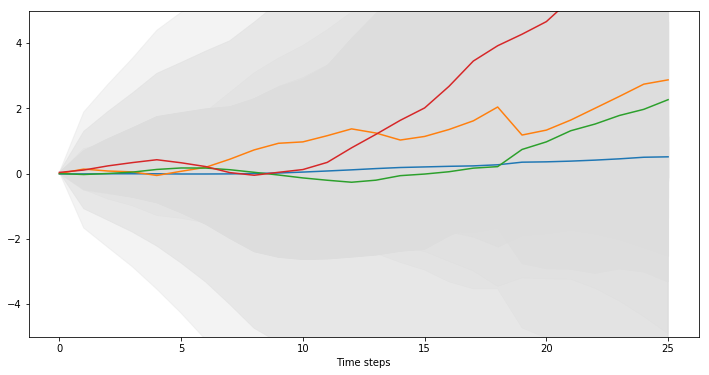

In [39]:
plot_variance(Z, ENCODING)

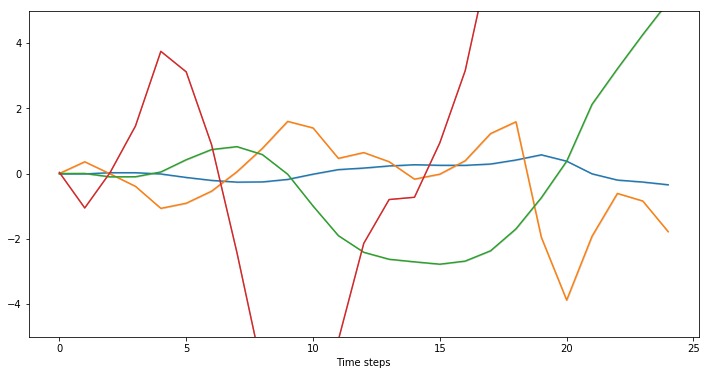

In [40]:
plot_variance(dataset[0], 4, std_scale=0)

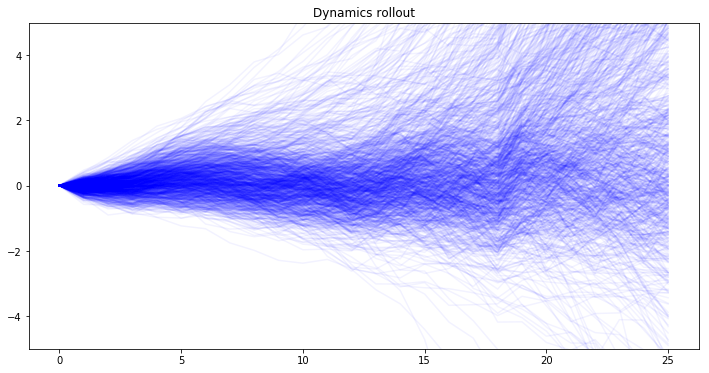

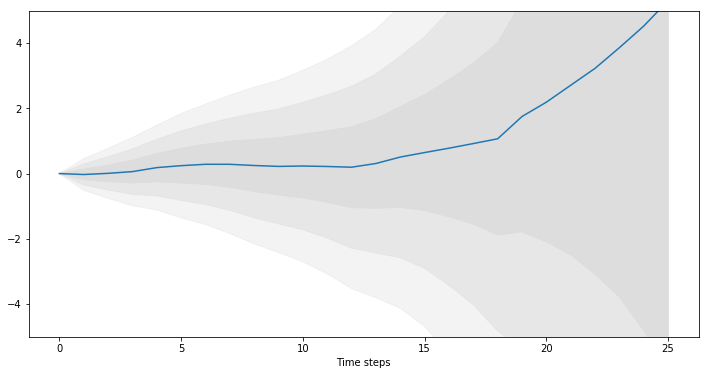

In [41]:
M = P.mean(0)
S = P.std(0)
S[0] += 1e-9
Z__ = pddp.utils.encoding.encode(M, S=S, encoding=ENCODING)
plot_particles(P, [2])
plot_variance(Z__, ENCODING, [2])

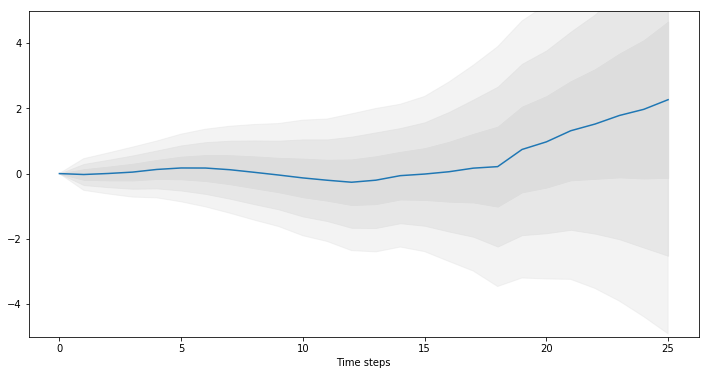

In [42]:
plot_variance(Z, ENCODING, [2])

In [36]:
P.var(0)

tensor([[   0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0009,    0.0442,    0.0262,    0.3512],
        [   0.0022,    0.1128,    0.0650,    0.9375],
        [   0.0041,    0.2199,    0.1219,    1.8779],
        [   0.0066,    0.3655,    0.1876,    3.3093],
        [   0.0105,    0.6078,    0.2843,    5.1050],
        [   0.0165,    0.9686,    0.3785,    7.4401],
        [   0.0256,    1.4535,    0.4994,   10.5469],
        [   0.0390,    2.1690,    0.6409,   14.2238],
        [   0.0568,    3.0512,    0.7745,   18.7286],
        [   0.0829,    4.1149,    0.9566,   23.6071],
        [   0.1183,    5.6939,    1.2018,   29.2408],
        [   0.1662,    7.8836,    1.5405,   36.5130],
        [   0.2398,   10.5519,    1.8829,   45.8265],
        [   0.3346,   14.3195,    2.3848,   58.2506],
        [   0.4662,   20.0735,    3.1518,   75.1005],
        [   0.6496,   28.7590,    4.4236,   98.9620],
        [   0.9077,   41.3741,    6.1026,  136.7757],
        [   1.2754,   61.271

In [37]:
pddp.utils.encoding.decode_var(Z, ENCODING)

tensor([[   0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0009,    0.0442,    0.0262,    0.3512],
        [   0.0022,    0.1128,    0.0650,    0.9375],
        [   0.0041,    0.2199,    0.1219,    1.8779],
        [   0.0066,    0.3655,    0.1876,    3.3093],
        [   0.0105,    0.6078,    0.2843,    5.1050],
        [   0.0165,    0.9686,    0.3785,    7.4401],
        [   0.0256,    1.4535,    0.4994,   10.5469],
        [   0.0390,    2.1690,    0.6409,   14.2238],
        [   0.0568,    3.0512,    0.7745,   18.7286],
        [   0.0829,    4.1149,    0.9566,   23.6071],
        [   0.1183,    5.6939,    1.2018,   29.2408],
        [   0.1662,    7.8836,    1.5405,   36.5130],
        [   0.2398,   10.5519,    1.8829,   45.8265],
        [   0.3346,   14.3195,    2.3848,   58.2506],
        [   0.4662,   20.0735,    3.1518,   75.1005],
        [   0.6496,   28.7590,    4.4236,   98.9620],
        [   0.9077,   41.3741,    6.1026,  136.7757],
        [   1.2754,   61.271